In [2]:
import pandas as pd
import scanpy as sc

# Load the dropout matrix (rows: genes, columns: cells) and immediately transpose
counts = pd.read_csv('C:\skole\fagproj\Fagprojekt-KID\data\data\S500\symsim_true_counts_20000genes_500cells_simple.csv', index_col=0)

# Now counts has rows=cells, cols=genes, just like Scanpy expects
adata = sc.AnnData(counts)

# Load your integer-indexed labels
labels = pd.read_csv(
    'data/S500_O/symsim_labels_20000genes_500cells_complex.csv',
    index_col=0
)

# If your cell barcodes come in as "X1","X2",… strip off the "X" and cast to int
adata.obs.index = adata.obs.index.str.lstrip('X').astype(int)

# Pull in the class labels
adata.obs['cell_class'] = labels.reindex(adata.obs.index)['x'].astype(str)


OSError: [Errno 22] Invalid argument: 'C:\\skole\x0cagproj\\Fagprojekt-KID\\data\\data\\S500\\symsim_true_counts_20000genes_500cells_simple.csv'

In [35]:
print("adata shape:", adata.shape)  # Should be (500, 20000)
print(adata.obs['cell_class'].value_counts(dropna=False))  # No NaNs!



adata shape: (500, 20000)
cell_class
4    63
5    63
6    63
7    63
1    62
2    62
3    62
8    62
Name: count, dtype: int64


In [36]:
print(adata)


AnnData object with n_obs × n_vars = 500 × 20000
    obs: 'cell_class'


In [38]:
import numpy as np
import scanpy as sc
from sklearn.manifold import trustworthiness
from sklearn.metrics import silhouette_score, adjusted_rand_score

trustworthiness_scores = []
silhouette_scores = []
ari_scores = []

# Ensure you have Leiden labels for ARI
adata.obs['cell_class'] = adata.obs['cell_class'].astype(str)

for i in range(10):
    print(f"Run: {i+1}/10")
    
    # Recompute neighbors & UMAP each iteration
    sc.pp.neighbors(adata, n_neighbors=15, use_rep='X', metric='euclidean')
    sc.tl.umap(adata, random_state=None)
    
    # Leiden clustering for ARI (change resolution if needed)
    sc.tl.leiden(adata, resolution=1.0, random_state=None)

    # Trustworthiness
    tw = trustworthiness(adata.X, adata.obsm['X_umap'], n_neighbors=15)
    trustworthiness_scores.append(tw)

    # Silhouette Score
    sil_score = silhouette_score(adata.obsm['X_umap'], adata.obs['cell_class'])
    silhouette_scores.append(sil_score)

    # Adjusted Rand Index (Leiden vs. known labels)
    ari = adjusted_rand_score(adata.obs['cell_class'], adata.obs['leiden'])
    ari_scores.append(ari)

# Calculate mean and variance
print("\nSummary Metrics (10 runs):")
print(f"Mean Trustworthiness: {np.mean(trustworthiness_scores):.4f}, Variance: {np.var(trustworthiness_scores):.6f}")
print(f"Mean Silhouette Score: {np.mean(silhouette_scores):.4f}, Variance: {np.var(silhouette_scores):.6f}")
print(f"Mean ARI: {np.mean(ari_scores):.4f}, Variance: {np.var(ari_scores):.6f}")

Run: 1/10
Run: 2/10
Run: 3/10
Run: 4/10
Run: 5/10
Run: 6/10
Run: 7/10
Run: 8/10
Run: 9/10
Run: 10/10

Summary Metrics (10 runs):
Mean Trustworthiness: 0.9416, Variance: 0.000002
Mean Silhouette Score: 0.1863, Variance: 0.000381
Mean ARI: 0.4744, Variance: 0.000000


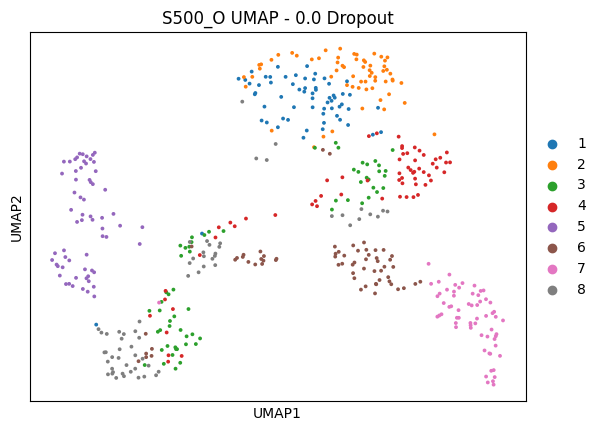

In [37]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X', metric='euclidean')
sc.tl.umap(adata, random_state=42)
sc.pl.umap(adata, color="cell_class", size=30, title="S500_O UMAP - 0.0 Dropout")